In [1]:
%pip install -qU pypdf
%pip install -U langchain
%pip install -U langchain-community
%pip install -U langchain-groq
%pip install langchain-huggingface
%pip install langgraph
%pip install python-dotenv

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /home/bender/.virtualenvs/flash-skills-rag-agentes-ia/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /home/bender/.virtualenvs/flash-skills-rag-agentes-ia/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /home/bender/.virtualenvs/flash-skills-rag-agentes-ia/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
/bin/bash: warning: setlocale: LC_ALL: cann

# Perguntando sobre Marte

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()  # Carrega variáveis do .env

api_key = os.getenv('GROQ_API_KEY')
huggingface_token = os.getenv('HUGGINGFACE_TOKEN')
print(api_key)  # Verifique se foi carregado corretamente
print(huggingface_token)

None
None


In [3]:
from langchain_groq import ChatGroq

In [4]:
llm = ChatGroq(model='llama-3.3-70b-versatile')

GroqError: The api_key client option must be set either by passing api_key to the client or by setting the GROQ_API_KEY environment variable

In [48]:
prompt = """
    messages: Segundo a NASA quais seriam os benefícios científicos de ir para Marte?
    """

In [49]:
resposta = llm.invoke(prompt)

In [50]:
resposta

AIMessage(content='A NASA identificou vários benefícios científicos em enviar missões tripuladas para Marte. Aqui estão alguns dos principais objetivos e vantagens científicas:\n\n1. **Entendimento da Formação e Evolução do Sistema Solar**: Marte é considerado um "irmão" mais antigo da Terra, oferecendo uma janela para o passado do Sistema Solar. Estudar Marte pode fornecer insights sobre a formação e evolução dos planetas terrestres.\n\n2. **Busca por Vida Passada ou Presente**: Uma das questões mais fundamentais da exploração espacial é se estamos sós no universo. Marte, com sua superfície hostil mas que pode ter sido mais hospitaleira no passado, é um alvo primário na busca por evidências de vida extraterrestre, seja ela passada ou presente.\n\n3. **Geologia e Clima de Marte**: A superfície de Marte é marcada por vastas planícies vulcânicas, o maior vulcão do Sistema Solar (Olympus Mons), e cânions imensos, como o Valles Marineris. Estudar essas formações pode revelar detalhes sobre

# Carregando um pdf

In [51]:
url = 'https://raw.githubusercontent.com/allanspadini/curso-flash-rag/main/m2m_strategy_and_objectives_development.pdf'

In [81]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(url)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [53]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 18.2 (Windows)', 'creationdate': '2023-04-06T17:28:28-04:00', 'moddate': '2023-04-06T17:29:25-04:00', 'trapped': '/False', 'source': 'https://raw.githubusercontent.com/allanspadini/curso-flash-rag/main/m2m_strategy_and_objectives_development.pdf', 'total_pages': 78, 'page': 0, 'page_label': '1'}

NASA’S 
MOON TO MARS 
STRATEGY AND 
OBJECTIVES 
DEVELOPMENT
A blueprint for sustained 
human presence and 
exploration throughout 
the Solar System
National Aeronautics and
Space Administration


# Base de dados vetorial

In [67]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings

In [80]:
import os
from huggingface_hub import InferenceClient

client = InferenceClient(
    provider="hf-inference",
    api_key=huggingface_token,
)
result = client.feature_extraction(
    "Today is a sunny day and I will get some ice cream.",
    model="mixedbread-ai/mxbai-embed-large-v1",
)



In [56]:
%pip install sentence-transformers
embed_model = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /home/bender/.virtualenvs/flash-skills-rag-agentes-ia/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [57]:
vector_store = InMemoryVectorStore.from_documents(pages, embed_model)

# Buscando informações

In [58]:
docs = vector_store.similarity_search("Objectives Development Process", k=2)

In [59]:
for doc in docs:
    print(f'Page {doc.metadata["page"]}: {doc.page_content[:300]}\n')

Page 42: APPENDIX B: OBJECTIVES DEVELOPMENT PROCESS
In accordance with the methodology principle of Architect from the Right, in November 2021, the NASA Executive Council 
tasked the mission directorates to draft a set of top-level goals and objectives necessary to achieve the Moon to Mars 
endeavor. The tas

Page 13: objective-baSed approach architect From the riGht / execute From the leFt
Architect from the right 
– work backwards from 
the defined goal and 
establish a complete set 
of elements that will be 
required for success.
NASA’s Moon to Mars strategy is guided by both a robust systems engineering proce



# Pipeline RAG

In [71]:
retriever = vector_store.as_retriever()

In [72]:
from langchain_core.prompts import ChatPromptTemplate

In [73]:
template = """You're a helpful assistant that only gives answers bases on the given context. If the answer is not in the context, say "I don't know".

Context:
{context}

Question:
{question}

Answer:"""

In [63]:
prompt = ChatPromptTemplate.from_template(template)

In [64]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [79]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [82]:
from IPython.display import display, Markdown

In [83]:
response = chain.invoke("What are the Objectives Development Process?")
Markdown(response)

The Objectives Development Process is described in Appendix B and also mentioned in other parts of the context. According to the context, in November 2021, NASA leadership began to identify top-level goals and objectives related to the blueprint vision and Moon to Mars strategy. The Federated Board facilitated approval of these goals and objectives, which were binned into four distinct tracks: 

1. Operations
2. Infrastructure
3. Transportation and Habitation
4. Science

The original nine goals and 50 draft objectives were released to the public and the NASA workforce in May 2022 with a request for comments by June 2022. NASA received more than 5,000 inputs, which resulted in modification of many objectives and the addition of several new ones. NASA held consultation workshops with both industry and international partners to continue to refine the objectives and identify gaps, welcoming the substantive and influential feedback.

The resulting revised 10 goals and 63 final objectives reflect a matured strategy for NASA and its partners to develop a blueprint for sustained human presence and exploration throughout the solar system via the Moon to Mars endeavor. 

Additionally, the context mentions that the Aeronautics Mission Directorate supported the Science Mission Directorate with the Science objectives and was actively involved in the entire objectives development process. The Federated Board reached consensus on an initial draft set of 45 objectives by March 2022. 

The process of architecting from the right can be carried down with increasing specificity to establish a full plan, and once the wireframe is fully architected by looking toward the future state, element development follows from the left, integrating into the blueprint architecture as development advances.

# Criando uma ferramenta

In [84]:
from langchain_core.tools import tool

In [85]:
@tool
def pega_contexto(query: str) -> str:
    """Pega o contexto baseado em uma pesquisa."""
    retriever = vector_store.as_retriever()
    resultado = retriever.invoke(query)
    return resultado

In [87]:
async def carrega_pdf(url: str):
    loader = PyPDFLoader(url)
    pages = []
    async for page in loader.alazy_load():
        pages.append(page)
    vectorstore = InMemoryVectorStore.from_documents(pages, embed_model)
    return vectorstore

In [88]:
import asyncio

async def load_vector_stores():
    global vector_store_agriculture, vector_store_dengue
    vector_store_agriculture = await carrega_pdf('https://raw.githubusercontent.com/allanspadini/curso-flash-rag/main/agriculture.pdf')
    vector_store_dengue = await carrega_pdf('https://raw.githubusercontent.com/allanspadini/curso-flash-rag/main/dengue.pdf')

await load_vector_stores()

In [89]:
@tool
def pega_contexto_agriculture(query: str) -> str:
    """Pega o contexto sobre agricultura baseado em uma pesquisa."""
    retriever = vector_store_agriculture.as_retriever()
    resultado = retriever.invoke(query)
    return resultado

In [90]:
@tool
def pega_contexto_dengue(query: str) -> str:
    """Pega o contexto sobre dengue baseado em uma pesquisa."""
    retriever = vector_store_dengue.as_retriever()
    resultado = retriever.invoke(query)
    return resultado

In [91]:
tools = [pega_contexto,pega_contexto_agriculture,pega_contexto_dengue]

In [93]:
pega_contexto_dengue.invoke("Cases of dengue we had since the beginning of 2025?")

[Document(id='cc3c0228-0498-4402-907b-83c203bf1a09', metadata={'producer': 'Microsoft® Word for Microsoft 365', 'creator': 'Microsoft® Word for Microsoft 365', 'creationdate': '2022-04-05T11:18:49+02:00', 'author': 'ECDC', 'keywords': 'dengue; annual epidemiological report; EU/EEA', 'moddate': '2022-04-05T11:21:18+02:00', 'subject': 'Dengue', 'title': 'Dengue - Annual Epidemiological Report for 2020', 'source': 'https://raw.githubusercontent.com/allanspadini/curso-flash-rag/main/dengue.pdf', 'total_pages': 8, 'page': 0, 'page_label': '1'}, page_content='Suggested citation: European Centre for Disease Prevention and Control. Dengue. In: ECDC. Annual epidemiological report for \n2020. Stockholm: ECDC; 2022. \n \nStockholm, April 2022 \n \n© European Centre for Disease Prevention and Control, 2022. Reproduction is authorised, provided the source is acknowledged. \n \n \n \n \n \n \n \n \n \n \n \n SURVEILLANCE REPORT \nDengue \n \nAnnual Epidemiological Report for 2020 \n \n \n \n \n \nKe

# Agentic RAG

In [94]:
from langgraph.prebuilt import create_react_agent

In [95]:
system_prompt = """ You're a helpful assistant that only gives answers bases on the given context. If the answer is not in the context, say "I don't know"
    - pega_contexto: Tool that returns the context based on the users query if the query is about NASA and space travels.
    - pega_contexto_agriculture: Tool that returns the context based on the users query if the query is about agriculture.
    - pega_contexto_dengue: Tool that returns the context based on the users query if the query is about dengue.
"""

In [96]:
agente_pdf = create_react_agent(model=llm, tools=tools, prompt=system_prompt)

In [ ]:
resultado= agente_pdf.invoke({"messages": [("user", "What are the Objectives Development Process?")]})

In [ ]:
resultado

{'messages': [HumanMessage(content='What are the Objectives Development Process?', additional_kwargs={}, response_metadata={}, id='8ec97c27-4d39-4d26-b450-c90c3c784603'),
  AIMessage(content="I don't know", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 5, 'prompt_tokens': 492, 'total_tokens': 497, 'completion_time': 0.021147964, 'prompt_time': 0.031728376, 'queue_time': 0.056525611, 'total_time': 0.05287634}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9a8b91ba77', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--d4e42b62-c047-4914-bdf1-51a1198e6002-0', usage_metadata={'input_tokens': 492, 'output_tokens': 5, 'total_tokens': 497})]}

In [ ]:
resultado= agente_pdf.invoke({"messages": [("user", "What causes dengue?")]})
resultado

{'messages': [HumanMessage(content='What causes dengue?', additional_kwargs={}, response_metadata={}, id='6457e19b-ea4d-4b77-a75e-2c2e353c20ac'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'km32b91pd', 'function': {'arguments': '{"query":"dengue causes"}', 'name': 'pega_contexto_dengue'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 490, 'total_tokens': 513, 'completion_time': 0.071679112, 'prompt_time': 0.024892364, 'queue_time': 0.065049276, 'total_time': 0.096571476}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9a8b91ba77', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cff84798-8c06-4296-acaa-c8e667463779-0', tool_calls=[{'name': 'pega_contexto_dengue', 'args': {'query': 'dengue causes'}, 'id': 'km32b91pd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 490, 'output_tokens': 23, 'total_tokens': 513}),
  ToolMessage(content="[Document(i

In [ ]:
resultado= agente_pdf.invoke({"messages": [("user", "Why is agriculture crucial for India's economy, and what's its current need?")]})
resultado

{'messages': [HumanMessage(content="Why is agriculture crucial for India's economy, and what's its current need?", additional_kwargs={}, response_metadata={}, id='a1ccee4a-cea6-4942-a849-bb7012ff3425'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'g1ph8hbtr', 'function': {'arguments': '{"query":"Importance and current needs of agriculture in India\'s economy"}', 'name': 'pega_contexto_agriculture'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 500, 'total_tokens': 530, 'completion_time': 0.083741109, 'prompt_time': 0.02528431, 'queue_time': 0.06435504, 'total_time': 0.109025419}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3b31bd11-be0e-4ac3-b035-05ce295934aa-0', tool_calls=[{'name': 'pega_contexto_agriculture', 'args': {'query': "Importance and current needs of agriculture in India's econ

# Definindo um grafo com memória

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition

from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage

In [ ]:
grafo = StateGraph(MessagesState)

In [ ]:
grafo.add_node("assistente", agente_pdf)
grafo.add_node("tools", ToolNode(tools))

In [ ]:
grafo.add_edge(START, "assistente")
grafo.add_conditional_edges("assistente",tools_condition,)

In [ ]:
grafo.add_edge("tools", "assistente")
grafo.add_edge("assistente",END)

In [ ]:
memoria = MemorySaver()
app = grafo.compile(checkpointer=memoria)

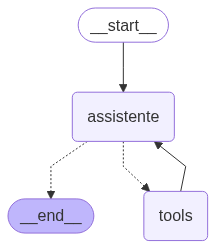

In [ ]:
Image(app.get_graph().draw_mermaid_png())

In [ ]:
def chat_com_memoria(mensagem_usuario: str, thread_id="1", verbose = False):
  config = {"configurable": {"thread_id": thread_id}}
  messages = app.invoke({"messages": [HumanMessage(content=mensagem_usuario)]}, config)
  if verbose:
        for message in messages['messages']:
            message.pretty_print()
  else:
      messages['messages'][-1].pretty_print()





In [ ]:
chat_com_memoria(mensagem_usuario="Why is agriculture crucial for India's economy, and what's its current need?", thread_id="2", verbose = False)

================================== Ai Message ==================================

Agriculture is the most important factor of the Indian economy, but this vital industry currently needs more support than any other. The current need of agriculture in India's economy is to improve productivity, minimize production costs, and utilize natural resources efficiently. This can be achieved by adopting emerging technologies such as data analytics, IoT, and smart farming technologies. Effective data analysis can help predict production values and market rates, and R Tool can be used to analyze agriculture data in various aspects, including crop production details, season-wise production, and year-wise production.


In [ ]:
chat_com_memoria(mensagem_usuario="What is the planet NASA is going?", thread_id="2", verbose = False)

================================== Ai Message ==================================

NASA is going to Mars.


In [ ]:
chat_com_memoria(mensagem_usuario="What planet again?", thread_id="2", verbose = False)

================================== Ai Message ==================================

Mars.
